# Time cost comparison (mnist classifier, tensorflow vs. iree)

## 1. Set envargs

In [1]:
import os
ad_root = os.environ["ad_root"]

## 2. Create model

In [2]:
import tensorflow as tf

NUM_CLASSES = 10
NUM_ROWS, NUM_COLS = 28, 28
BATCH_SIZE = 1

class SampleModule(tf.Module):
    def __init__(self):
        super().__init__()
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(NUM_ROWS, NUM_COLS)),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(10, activation="softmax")
        ])
        
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        
    @tf.function(
        input_signature=[
            tf.TensorSpec([BATCH_SIZE, NUM_ROWS, NUM_COLS, 1])
        ]
    )
    def forward(self, inputs):
        return self.model(inputs, training=False)
    
    @tf.function(
        input_signature=[
            tf.TensorSpec([BATCH_SIZE, NUM_ROWS, NUM_COLS, 1]),
            tf.TensorSpec([BATCH_SIZE], tf.uint8)
        ]
    )
    def backward(self, inputs, labels):
        with tf.GradientTape() as tape:
            probs = self.forward(inputs)
            loss = self.loss(labels, probs)
        
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        return gradients
    
    @tf.function(
        input_signature=[
            tf.TensorSpec([BATCH_SIZE, NUM_ROWS, NUM_COLS, 1]),
            tf.TensorSpec([BATCH_SIZE], tf.uint8)
        ]
    )
    def learn(self, inputs, labels):
        with tf.GradientTape() as tape:
            probs = self.model(inputs, training=True)
            loss = self.loss(labels, probs)
            
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return loss
    
m = SampleModule()

## 3. Save model

```python
tf.saved_model.save(m, model_path, signatures={"forward": m.forward, "backward": m.backward, "learn": m.learn})
```

## 4. Import model as MLIR using iree-import-tf

```sh
iree-import-tf model_path --tf-savedmodel-exported-names="forward" --output-format=mlir-ir --tf-import-type=savedmodel_v2 --use-tosa -o classifier.mlir
```

## 5. Preprocess the imported MLIR (iree dialect is illegal in AD context)
    * remove the `forward` function
    * make the private function public
    
```sh
sed "s/func.func private/func.func/g"
```

## 6. Apply autodiff on MLIR using autodiff-opt

```sh
autodiff-opt classifier.mlir --autodiff -o autodiff.mlir
```

## 7. Read autodiff.mlir and construct `TosaIR` instance

In [3]:
from ad.intermediate import TosaIR
from ad.utils import timer_us, alloc_to_init

mlir_path = f"{ad_root}/test/e2e/mnist/autodiff.mlir"

with open(mlir_path, "r") as f:
    lines = f.read().split("\n")
    for i in range(len(lines)):
        lines[i] = alloc_to_init(lines[i])
    file_input = "\n".join(lines)
    
tosa_ir = TosaIR(file_input)
tosa_exe = tosa_ir.to_executable()

## 8. Choose a random image for testing

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "monospace"
plt.rcParams["figure.figsize"] = [8, 4.5]
plt.rcParams["figure.dpi"] = 150

def show_image(x_set, y_set, index):
    plt.figure(figsize=(5, 5))
    plt.imshow(x_set[index].reshape(NUM_ROWS, NUM_COLS), cmap="gray")
    plt.title(f"Sample #{index}, label: {y_set[index]}")
    plt.axis("off")
    plt.tight_layout()  

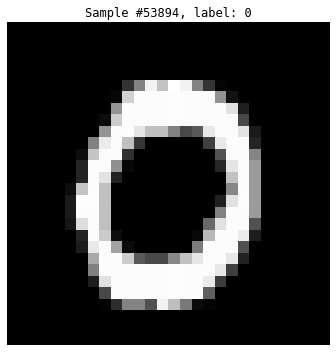

In [5]:
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.reshape(x_train, (-1, NUM_ROWS, NUM_COLS, 1))
x_test = np.reshape(x_test, (-1, NUM_ROWS, NUM_COLS, 1))

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

index = np.random.randint(x_train.shape[0])
show_image(x_train, y_train, index)

## 9. Use cases

In [6]:
from ad.utils import timer_ns

@timer_ns
def run_tf():
    x_batch = [x_train[index]]
    y_batch = [y_train[index]]

    gradients = m.backward(x_batch, y_batch)
    return gradients

@timer_ns
def run_iree():
    image = np.reshape(np.array(x_train[index]), (BATCH_SIZE, NUM_ROWS, NUM_COLS, 1))
    contribution = np.reshape(np.array([1 if i == y_train[index] else 0 for i in range(10)], dtype=np.float32), (BATCH_SIZE, 10))
    
    res = tosa_exe.exec(image, contribution)
    return res

In [7]:
tf_res, tf_time = run_tf()

run_tf : 325798209 ns


In [8]:
iree_res, iree_time = run_iree()

run_iree : 8473097 ns


## 10. Visualization

Text(0.5, 1.0, 'time cost (ms)')

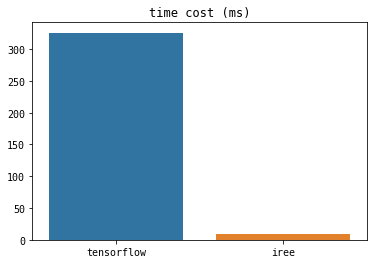

In [9]:
import pandas as pd
df = pd.DataFrame({ "tensorflow" : [tf_time / 1e6], "iree" : [iree_time / 1e6] })
sns.barplot(df).set_title("time cost (ms)")